## Import necessary libraries

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import ndreg
from ndreg import preprocessor, util, plotter
import SimpleITK as sitk

In [3]:
import numpy as np

In [4]:
import ndreg.vis as vis

In [5]:
import tensorflow as tf

In [6]:
from tqdm import tqdm_notebook,tqdm

In [7]:
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [8]:
def myshow(img, cmap='gray', colorbar=False):
    plt.imshow(sitk.GetArrayViewFromImage(img), cmap=cmap)
    if colorbar: plt.colorbar()
    plt.axis('off')
    plt.show()

In [70]:
def register_brain(atlas, img, vt0, niter=50, naffine=0, outdir=None):
    """Register 3D mouse brain to the Allen Reference atlas using affine and deformable registration.

    Parameters:
    ----------
    atlas : {SimpleITK.SimpleITK.Image}
        Allen reference atlas or other atlas to register data to.
    img : {SimpleITK.SimpleITK.Image}
        Input observed 3D mouse brain volume
    outdir : {str}, optional
        Path to output directory to store intermediates. (the default is None, which will store all outputs in './')

    Returns
    -------
    SimpleITK.SimpleITK.Image
        The atlas deformed to fit the input image.
    """
    if outdir is None: outdir = './'
    # whitening_radius = [int(i) for i in np.array([0.5, 0.5, 0.5]) / np.array(atlas.GetSpacing())] # mm
    # resample both images to `spacing`
    # atlas_ds = preprocessor.imgResample(atlas, spacing)
    # img_ds = preprocessor.imgResample(img, spacing)
    # final_transform = register_affine(sitk.Normalize(atlas_ds),
    #                                             sitk.Normalize(img_ds),
    #                                             learning_rate=1e-1,
    #                                             grad_tol=4e-6,
    #                                             iters=50,
    #                                             shrink_factors=[4,2,1],
    #                                             sigmas=[0.4, 0.2, 0.1],
    #                                             verbose=False)
    # save the affine transformation to outdir
    # make the dir if it doesn't exist
#     util.dir_make(outdir)
    # sitk.WriteTransform(final_transform, outdir + 'atlas_to_observed_affine.txt')
    # atlas_affine = resample(atlas_ds, final_transform, img_ds, default_value=util.img_percentile(atlas,0.01))

    # whiten both images only before lddmm                                                                                                                                                              [507/4876]    # whiten both images only before lddmm
    # atlas_affine_w = sitk.AdaptiveHistogramEqualization(atlas_affine, whitening_radius, alpha=0.25, beta=0.25)
    # img_w = sitk.AdaptiveHistogramEqualization(img_ds, whitening_radius, alpha=0.25, beta=0.25)



    # then run lddmm
    # e = 5e-3
    # s = 0.1
    # atlas_lddmm, field, inv_field = register_lddmm(sitk.Normalize(atlas_affine_w),
    #                                                 sitk.Normalize(img_w),
    #                                                 alpha_list=[0.05],
    #                                                 scale_list = [0.0625, 0.125, 0.25, 0.5, 1.0],
    #                                                 epsilon_list=e, sigma=s,
    #                                                 min_epsilon_list=e*1e-6,
    #                                                 use_mi=False, iterations=50, verbose=True,
    #                                                 out_dir=outdir + 'lddmm')

    # field_up = preprocessor.imgResample(field, atlas.GetSpacing())
    # atlas_affine_up = imgApplyAffine(atlas, final_transform)
    # atlas_lddmm_up = imgApplyField(atlas_affine_up, field_up)
    I = sitk.GetArrayFromImage(atlas)
    J = sitk.GetArrayFromImage(img)
    nxI = list(I.shape)
    dxI = np.array(atlas.GetSpacing())[::-1]
    nxJ = list(J.shape)
    dxJ = np.array(img.GetSpacing())[::-1]
    xI = [np.arange(nxi)*dxi - np.mean(np.arange(nxi)*dxi) for nxi,dxi in zip(nxI,dxI)]
    xJ = [np.arange(nxi)*dxi - np.mean(np.arange(nxi)*dxi) for nxi,dxi in zip(nxJ,dxJ)]

    # I would like to pad one slice of the allen atlas so that it has zero boundary conditions
#     zeroslice = np.zeros((nxI[0],1,nxI[2]))
#     I = np.concatenate((I,zeroslice),axis=1)
    I = np.pad(I,[(0,0),(0,0),(0,1)],'constant',constant_values=0)
    nxI =  list(I.shape)
    xI = [np.arange(nxi)*dxi - np.mean(np.arange(nxi)*dxi) for nxi,dxi in zip(nxI,dxI)]

    # parameters
    # cost function weights 1 / sigma^2
    sigmaM = np.std(J) # matching
    sigmaA = sigmaM*10.0 # artifact
    sigmaR = 1e0 # regularization

    # enery operator, power of laplacian p, characteristic length a
    p = 2
    a = (xI[0][1]-xI[0][0])*5

    # other optimization parameters
#     niter = 10 # how many iteraitons of gradient descent
#     naffine = 0 # first naffine iterations are affine only (no deformation)
    nt = 5 # this many timesteps to numerically integrate flow

    # When working with weights in EM algorithm, how many M steps per E step
    # first test with 0 (it is working)
    nMstep = 5
    nMstep_affine = 1

    # gradient descent step size
    eL = 2e-4
    eT = 5e-3
    eV = 1e-2
    # there is some oscilation in the translation and the linear part
    if vt0 == None:
        vt0 = [None]*3
    out = lddmm.lddmm(I, J,
                  xI=xI, # location of pixels in domain
                  xJ=xJ,
                  niter=niter, # iterations of gradient descent
                  naffine=naffine, # iterations of affine only
                  eV = eV, # step size for deformation parameters
                  eT = eT, # step size for translation parameters
                  eL = eL, # step size for linear parameters
                  nt=nt, # timesteps for integtating flow
                  sigmaM=sigmaM, # matching cost weight 1/2sigmaM^2
                  sigmaR=sigmaR, # reg cost weight 1/2sigmaM^2
                  sigmaA=sigmaA, # artifact cost weight 1/2sigmaA^2
                  a=a, # kernel width
                  p=p, # power of laplacian in kernel (should be at least 2 for 3D)
#                  A0=A0, # initial guess for affine matrix (should get orientation right)
                  nMstep=nMstep, # number of m steps for each e step
                  nMstep_affine=nMstep_affine, # number of m steps during affine only phase
                  verbose=1,
                  vt00=vt0[0],
                  vt01=vt0[1],
                  vt02=vt0[2]
                 )
    util.write_lddmm_output(out,outdir)
    atlas_deformed = apply_transformation_to(I,xI,out['phiinvAinv0'],out['phiinvAinv1'],out['phiinvAinv2'])
    return atlas_deformed, out

def apply_transformation_to(image,x,trans_x,trans_y,trans_z):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        Id = lddmm.interp3(x[0],x[1],x[2],image,trans_x,trans_y,trans_z)
        Idnp = Id.eval()
    return Idnp

### Some metadata is required before registration

In [55]:
params = {
    # input image path
    'image_path': './data/Thy1eYFP_Control_9.tiff',
    # voxel spacing is in mm and corresponds to (x, y, z) spacing
    'image_spacing': (0.04128, 0.04128, 0.04128),
    'image_orientation': 'rpi',
    # the modality can be 'lavision' or 'colm'
    'image_modality': 'lavision',
    'atlas_spacing': (0.05, 0.05, 0.05),
    'atlas_path': './data/ARA_50um.tiff',
}

## Load the sample data

In [56]:
img = util.imgRead(params['image_path'])
img.SetSpacing(params['image_spacing'])
atlas = util.imgRead(params['atlas_path'])
atlas.SetSpacing(params['atlas_spacing'])

In [57]:
atlas.GetSize()

(264, 160, 228)

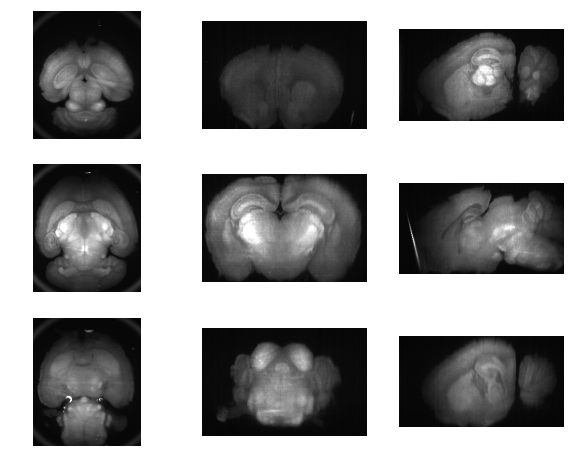

In [58]:
plotter.imgShow(img, vmax=2000)

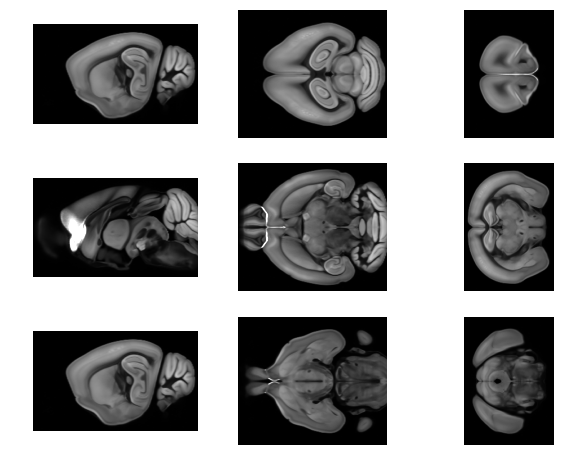

In [59]:
plotter.imgShow(atlas, vmax=400)

## Preprocessing
This step preprocesses the input CLARITY images by resampling them to match the resolution of the atlas, bias correcting the images, and normalizing them by subtracting the mean and dividing by the standard deviation of the image intensities.

In [60]:
img_p = preprocessor.preprocess_brain(img, 
                                      [0.20]*3, 
                                      params['image_modality'],
                                      params['image_orientation'])

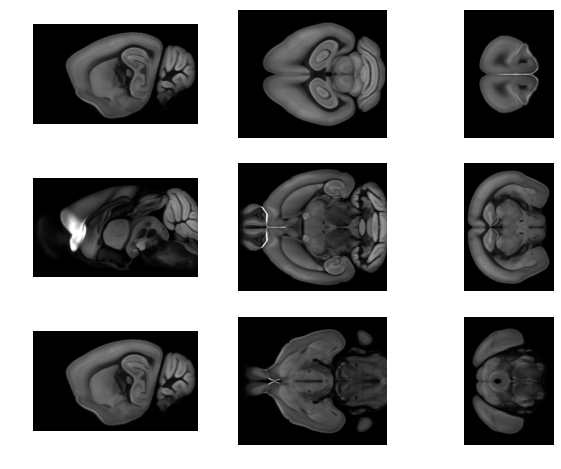

In [61]:
plotter.imgShow(atlas)

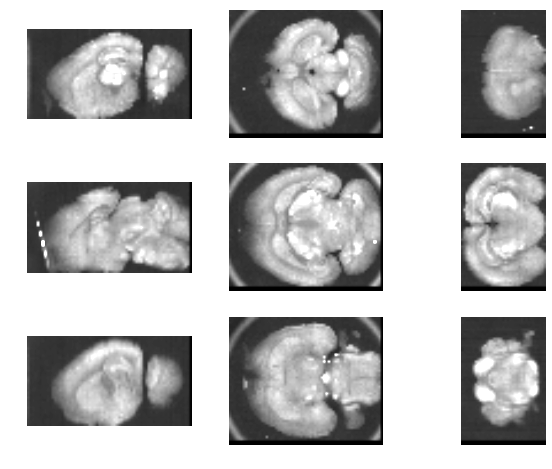

In [62]:
plotter.imgShow(img_p,vmax=2)

The output of this method is the atlas registered to the raw data

In [63]:
from ndreg import lddmm
def get_grid_locations(shape,spacing):
    x = [np.arange(nxi)*dxi - np.mean(np.arange(nxi)*dxi) for nxi,dxi in zip(list(shape),spacing)]
#     x_meshgrid = np.meshgrid(x[0],x[1],x[2],indexing='ij')
    return x
    
def resample(image,image_meshgrid,transformation):
#     grid_locations = get_meshgrid(image,spacing)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        image_r = lddmm.interp3(image_meshgrid[0],image_meshgrid[1],image_meshgrid[2],
                                image,
                                transformation[0],transformation[1],transformation[2])
        image_rnp = image_r.eval()
    return image_rnp

In [64]:
resolutions = [0.25,.5,1.]
spacings = [np.array(params['atlas_spacing'])/i for i in resolutions]

In [65]:
I = sitk.GetArrayFromImage(atlas)
nxI = list(I.shape)
dxI = np.array(atlas.GetSpacing())[::-1]
xI = [np.arange(nxi)*dxi - np.mean(np.arange(nxi)*dxi) for nxi,dxi in zip(nxI,dxI)]

# I would like to pad one slice of the allen atlas so that it has zero boundary conditions
zeroslice = np.zeros((nxI[0],1,nxI[2]))
I = np.concatenate((I,zeroslice),axis=1)
nxI[1] += 1
xI = [np.arange(nxi)*dxi - np.mean(np.arange(nxi)*dxi) for nxi,dxi in zip(nxI,dxI)]

In [66]:
nxI

[228, 161, 264]

In [ ]:
%%time
tmp_atlas = None
tmp_vt = None
shapes = []
# niter=50
for i,j in tqdm(enumerate(spacings)):
    # downsample the images
    img_ds = preprocessor.preprocess_brain(img, 
                                          j, 
                                          params['image_modality'],
                                          params['image_orientation'])
    
    #  downsample atlas
    atlas_ds = preprocessor.imgResample(atlas,j)
    atlas_dsnp = sitk.GetArrayViewFromImage(atlas_ds)
    ## pad atlas
    atlas_dsnp = np.pad(atlas_dsnp,[(0,0),(0,0),(0,1)],'constant',constant_values=0)
    ##
#     img_dsnp = sitk.GetArrayViewFromImage(img_ds)
    shapes.append(atlas_dsnp.shape)
    print("atlas_ds shape: {}".format(atlas_dsnp.shape))
    
    
    # if it's the  first iteration no need to deform the atlas
    if i == 0:
        # register at this resolution
        atlas_registered, out = register_brain(atlas_ds, img_ds, vt0=tmp_vt,niter=20,naffine=5)
        tmp_vt = [out['vt{}'.format(i)] for i in range(3)]
        # initial composite  transform
#         composite_transform = [out['phiinvAinv{}'.format(i)] for  i in range(3)]
#         x = get_grid_locations(atlas_ds,j)
#         old_pos = np.meshgrid(x[0],x[1],x[2],indexing='ij')
#         composite_displacements = [c1 - c2  for c1,c2 in zip(composite_transform,old_pos)]
    else:
        tmp_vt2 = []
        old_pos = get_grid_locations(shapes[i-1],spacings[i-1])
#         old_pos = np.meshgrid(x1[0],x1[1],x1[2],indexing='ij')
        x2 = get_grid_locations(shapes[i],spacings[i])
        new_positions = np.meshgrid(x2[0],x2[1],x2[2],indexing='ij')
        new_shape = new_positions[0].shape
        for v in tmp_vt:
            tmp_t = np.zeros((new_shape[0],new_shape[1],new_shape[2],5),dtype='float32')
            for t in range(v.shape[-1]):
                tmp_t[:,:,:,t] = resample(v[:,:,:,t],old_pos,new_positions)
            print("shape of upsampled velocity: {}".format(tmp_t.shape))
            tmp_vt2.append(tmp_t)
                
        tmp_vt = tmp_vt2
        atlas_registered, out = register_brain(atlas_ds, img_ds, vt0=tmp_vt,niter=50)
        tmp_vt = [out['vt{}'.format(i)] for i in range(3)]



0it [00:00, ?it/s]

atlas_ds shape: (57, 40, 67)
Updating weights
Finished iteration 0, energy 2.629539e+02 (match 2.629539e+02, reg 0.000000e+00)
Updating weights
Finished iteration 1, energy 1.792693e+02 (match 1.792693e+02, reg 0.000000e+00)
Updating weights
Finished iteration 2, energy 1.716967e+02 (match 1.716967e+02, reg 0.000000e+00)
Updating weights
Finished iteration 3, energy 1.699194e+02 (match 1.699194e+02, reg 0.000000e+00)
Updating weights
Finished iteration 4, energy 1.685357e+02 (match 1.685357e+02, reg 0.000000e+00)
Updating weights
Finished iteration 5, energy 1.677049e+02 (match 1.677049e+02, reg 0.000000e+00)
Finished iteration 6, energy 1.676010e+02 (match 1.676006e+02, reg 3.838607e-04)
Finished iteration 7, energy 1.675113e+02 (match 1.675098e+02, reg 1.516896e-03)
Finished iteration 8, energy 1.674299e+02 (match 1.674266e+02, reg 3.370369e-03)
Finished iteration 9, energy 1.673566e+02 (match 1.673506e+02, reg 5.916637e-03)
Updating weights
Finished iteration 10, energy 1.672903e+02

In [28]:
new_shape = new_positions[0].shape

In [29]:
for v in tmp_vt:
    tmp_t = np.zeros((new_shape[0],new_shape[1],new_shape[2],5))
    for t in range(v.shape[-1]):
        tmp_t[:,:,:,t] = resample(v[:,:,:,t],old_pos,new_positions)
    print("shape of upsampled velocity: {}".format(tmp_t.shape))
    tmp_vt2.append(tmp_t_np)

shape of upsampled velocity: (114, 80, 132, 5)
shape of upsampled velocity: (114, 80, 132, 5)
shape of upsampled velocity: (114, 80, 132, 5)


In [ ]:
x = get_grid_locations(sitk.GetArrayViewFromImage(img_ds),[0.05]*3)
new_positions = np.meshgrid(x[0],x[1],x[2],indexing='ij')

In [ ]:
out['phiinvAinv2'] - new_positions[2]

In [ ]:
# apply upsampled transformation to atlas
atlas_t = resample(atlas_dsnp,get_grid_locations(atlas_dsnp,spacings[1]),
                   transformation_a2d_upsampled)
atlas_t = sitk.GetImageFromArray(atlas_t)
atlas_t.SetSpacing(spacings[1])

In [ ]:
vis.imshow_slices(atlas_t)

In [ ]:
atlas_registered, out = ndreg.register_brain(atlas_t, img_ds)

In [ ]:
#trilinear interpolation on high res image
# these points correspond to my image
X0,X1,X2 = np.meshgrid(x[0],x[1],x[2],indexing='ij')
X0tf = tf.constant(X0,dtype=lddmm.dtype)
X1tf = tf.constant(X1,dtype=lddmm.dtype)
X2tf = tf.constant(X2,dtype=lddmm.dtype)
Itf = tf.constant(I,dtype=lddmm.dtype)

# these correspond to my transformation, let's assume it is lower res
# we will just downsample it as a quick hack here
phi0 = X0+10
phi1 = X1*1.2
phi2 = X2 + X2**2*0.005
# downsample transformation phi
down = 3
phi0 = phi0[::down,::down,::down]
phi1 = phi1[::down,::down,::down]
phi2 = phi2[::down,::down,::down]
# downsample grid X
xphi = [x[0][::down], x[1][::down], x[2][::down]]
Xphi0,Xphi1,Xphi2 = np.meshgrid(xphi[0],xphi[1],xphi[2],indexing='ij')
# tensors
phi0tf = tf.constant(phi0,dtype=lddmm.dtype)
phi1tf = tf.constant(phi1,dtype=lddmm.dtype)
phi2tf = tf.constant(phi2,dtype=lddmm.dtype)
Xphi0tf = tf.constant(Xphi0,dtype=lddmm.dtype)
Xphi1tf = tf.constant(Xphi1,dtype=lddmm.dtype)
Xphi2tf = tf.constant(Xphi2,dtype=lddmm.dtype)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # first we upsample the transformation
    
    phi0up = lddmm.interp3(xphi[0],xphi[1],xphi[2],phi0tf,X0tf,X1tf,X2tf)
    phi1up = lddmm.interp3(xphi[0],xphi[1],xphi[2],phi1tf,X0tf,X1tf,X2tf)
    phi2up = lddmm.interp3(xphi[0],xphi[1],xphi[2],phi2tf,X0tf,X1tf,X2tf)
    
    Id = lddmm.interp3(x[0],x[1],x[2],Itf,phi0up,phi1up,phi2up)
    Idnp = Id.eval()
f = plt.figure()
vis.imshow_slices(Idnp,x=x,fig=f)
f.suptitle('Example of transforming by linear interpolation')
f.canvas.draw()


## Visualize registered image

The two images below should match if the registration worked successfully!

In [ ]:
vis.imshow_slices(atlas_registered)

In [ ]:
plotter.imgShow(sitk.GetImageFromArray(atlas_registered))

In [ ]:
plotter.imgShow(plotter.imgChecker(atlas_registered, img_p), vmax=2)

# Quantitative evaluation

Here, we print out the Mean Squared Error between both the atlas and the observed data. As we can see, this metric decreases from the unprocessed data (first cell below this one) to the final atlas registered to our data (3rd cell below this one)

In [ ]:
ndreg.imgMSE(sitk.Normalize(atlas), sitk.Normalize(img))

In [ ]:
ndreg.imgMSE(sitk.Normalize(atlas), sitk.Normalize(img_p))

In [ ]:
ndreg.imgMSE(sitk.Normalize(atlas_registered), sitk.Normalize(img_p))